In [1]:
from nmon import *

 /Users/nikolaygusarov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py: 34

nmon [-2.5117153  -0.43722867  1.37804491  3.11300492  3.78868674  6.72983865]


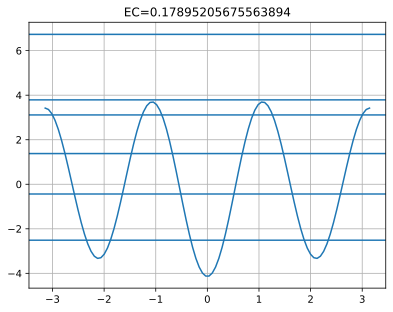

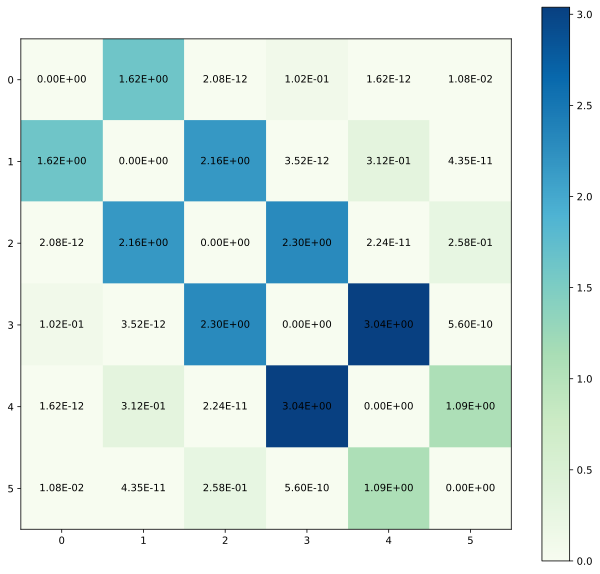

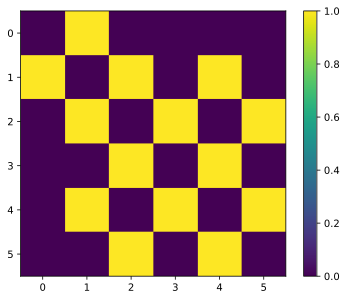

[2.074486636208185, 1.8152735761685266, 1.7349600121791515, 0.6756818157252198, 2.9411519098406242]


In [2]:
N = 1
M = 3
EC_shunt = 0.18 * 1

# choose sparse: 100/100, 100/10, 100/5, 100/3
# choose dense: 100/2

# nmon = Nmon(N=N, M=M, EJN=100*EC_shunt, EJM=100*EC_shunt, EC_shunt=EC_shunt)
nmon = Nmon(N=N, M=M, EJN=20*EC_shunt, EJM=1*EC_shunt, EC_shunt=EC_shunt)

nmon.hamiltonian_calc(flux=0.0, ng=[0.0, 0, 0, 0], num_levels=6, make_plot=True, just_H=False, cutoff=4)#compute_cutoff(nmon.EJN, nmon.EJM, nmon.EC_total, cutoff_space=[2, 8]))

print(nmon.transition_freqs)

In [3]:
nmon.nmon_circ.sym_hamiltonian(return_expr=True)

(16.974833*n2**2 + 16.974833*n_g2**2 + 16.743708*n1**2 + 16.743708*n3**2 + 16.743708*n_g1**2 + 16.743708*n_g3**2 + 16.974833*n2*n3 + 16.974833*n2*n_g3 + 16.974833*n3*n_g2 + 16.974833*n_g2*n_g3 + 33.949666*n2*n_g2 + 33.487417*n1*n_g1 + 33.487417*n3*n_g3 - 33.025167*n1*n2 - 33.025167*n1*n_g2 - 33.025167*n2*n_g1 - 33.025167*n_g1*n_g2 - 16.512583*n1*n3 - 16.512583*n1*n_g3 - 16.512583*n3*n_g1 - 16.512583*n_g1*n_g3) + (-18.0*cos(θ1) - 18.0*cos((2πΦ_{1}) - θ3) - 18.0*cos(θ1 + θ2) - 18.0*cos(θ2 - θ3))

In [4]:
import numpy as np

# in n - basis

def construct_hamiltonian(n_cut, Phi_1=0.0, n_g1=0.0, n_g2=0.0, n_g3=0.0):
    # Define the basis states
    basis = []
    for n1 in range(-n_cut, n_cut + 1):
        for n2 in range(-n_cut, n_cut + 1):
            for n3 in range(-n_cut, n_cut + 1):
                basis.append((n1, n2, n3))
    
    # Map basis states to indices
    n1n2n3_to_index = { (n1, n2, n3): idx for idx, (n1, n2, n3) in enumerate(basis) }
    
    # Initialize the Hamiltonian matrix
    dim = len(basis)
    H = np.zeros((dim, dim), dtype=complex)
    
    # Constants from the Hamiltonian
    # Charging energy coefficients
    E_n1_n1 = 16.74370801448822021484375
    E_n1_n2 = -33.016467
    E_n1_n3 = -16.508233
    E_n1_ng1 = 33.491767
    E_n1_ng2 = -33.016467
    E_n1_ng3 = -16.508233
    
    E_n2_n2 = 16.974833011627197265625
    E_n2_n3 = 16.983533
    E_n2_ng1 = -33.016467
    E_n2_ng2 = 33.967067
    E_n2_ng3 = 16.983533
    
    E_n3_n3 = 16.74370801448822021484375
    E_n3_ng1 = -16.508233
    E_n3_ng2 = 16.983533
    E_n3_ng3 = 33.491767
    
    E_ng1_ng1 = 16.745883
    E_ng1_ng2 = -33.016467
    E_ng1_ng3 = -16.508233
    
    E_ng2_ng2 = 16.983533
    E_ng2_ng3 = 16.983533
    
    E_ng3_ng3 = 16.745883
    
    # Charging energy terms (diagonal)
    for idx, (n1, n2, n3) in enumerate(basis):
        H_c = (
            E_n1_n1 * n1**2 +
            E_n2_n2 * n2**2 +
            E_n3_n3 * n3**2 +
            E_n1_n2 * n1 * n2 +
            E_n1_n3 * n1 * n3 +
            E_n2_n3 * n2 * n3
            # Offset charges are zero in this example, but can be included as needed
        )
        H[idx, idx] = H_c
    
    # Potential energy terms (off-diagonal)
    # V1: -18.0 * cos(θ1)
    for idx, (n1, n2, n3) in enumerate(basis):
        coeff = -9.0  # -18.0 / 2
        for delta_n1 in [-1, 1]:
            n1p = n1 + delta_n1
            if -n_cut <= n1p <= n_cut:
                idxp = n1n2n3_to_index.get((n1p, n2, n3))
                if idxp is not None:
                    H[idx, idxp] += coeff
    
    # V2: -18.0 * cos((2πΦ_1) - θ3)
    phi = 2 * np.pi * Phi_1
    exp_plus = np.exp(-1j * phi)
    exp_minus = np.exp(1j * phi)
    for idx, (n1, n2, n3) in enumerate(basis):
        coeff = -9.0
        # Shift n3 by +1 with exp(-i * phi)
        n3p = n3 + 1
        if -n_cut <= n3p <= n_cut:
            idxp = n1n2n3_to_index.get((n1, n2, n3p))
            if idxp is not None:
                H[idx, idxp] += coeff * exp_minus
        # Shift n3 by -1 with exp(i * phi)
        n3p = n3 - 1
        if -n_cut <= n3p <= n_cut:
            idxp = n1n2n3_to_index.get((n1, n2, n3p))
            if idxp is not None:
                H[idx, idxp] += coeff * exp_plus
    
    # V3: -0.18 * cos(θ1 + θ2)
    for idx, (n1, n2, n3) in enumerate(basis):
        coeff = -0.09 * 100  # -0.18 / 2
        for delta in [-1, 1]:
            n1p = n1 + delta
            n2p = n2 + delta
            if -n_cut <= n1p <= n_cut and -n_cut <= n2p <= n_cut:
                idxp = n1n2n3_to_index.get((n1p, n2p, n3))
                if idxp is not None:
                    H[idx, idxp] += coeff
    
    # V4: -18.0 * cos(θ2 - θ3)
    for idx, (n1, n2, n3) in enumerate(basis):
        coeff = -9.0  # -18.0 / 2
        for delta_n2 in [-1, 1]:
            delta_n3 = -delta_n2
            n2p = n2 + delta_n2
            n3p = n3 + delta_n3
            if -n_cut <= n2p <= n_cut and -n_cut <= n3p <= n_cut:
                idxp = n1n2n3_to_index.get((n1, n2p, n3p))
                if idxp is not None:
                    H[idx, idxp] += coeff
    
    # Ensure the Hamiltonian is Hermitian
    H = (H + H.conj().T) / 2
    return H.real  # Return the real part

# Example usage
n_cut = 7  # Charge basis cutoff
Phi_1 = 0.0  # External flux Φ_1 in units of Φ/Φ0
n_g1 = 0.0  # Offset charge n_g1
n_g2 = 0.0  # Offset charge n_g2
n_g3 = 0.0  # Offset charge n_g3

hamiltonian_matrix = construct_hamiltonian(n_cut, Phi_1, n_g1, n_g2, n_g3)
print("Hamiltonian matrix shape:", hamiltonian_matrix.shape)
# print("Hamiltonian matrix diagonal elements (rounded):")
# print(np.round(np.diag(hamiltonian_matrix), 2))

# Solve eigenvalue problem
# eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix)
# eigenvalues, eigenvectors = spla.eigsh(hamiltonian_matrix, which='SA')
eigenvalues, eigenvectors = compute_eigh(hamiltonian_matrix)
print("Eigenvalues (sorted):", sorted(eigenvalues))

# Compute the ratio as requested
max_diag = np.max(np.diag(hamiltonian_matrix))
size = hamiltonian_matrix.shape[0]
off_diag_element = hamiltonian_matrix[0, 1]
ratio = max_diag / size**2 / off_diag_element
print("Computed Ratio:", ratio)


Hamiltonian matrix shape: (3375, 3375)
Eigenvalues (sorted): [-41.53698317304274, -36.10198834696807, -30.820989762884196, -25.686286083642088, -20.66990280678604, -16.130670780184026, -16.127747424423426, -15.726483049265576, -10.970973708611353, -10.967679209142643, -10.823247932938873, -6.00693508976915, -5.984401779369415, -5.958395450121818, -1.8144197292287902, -1.3586415098224502, -1.1713293530187852, -1.1610762240863959, 2.2065895296805453, 3.1893249791641125, 3.490067073173751, 3.5091415221251885, 3.771054700896788, 3.772082410671884, 5.907367259485297, 5.951827404379482, 7.948907805918022, 8.022498837819505, 8.582700849313373, 8.584045845891866, 9.355441838894661, 12.11103921031089, 12.378626707884827, 12.420016771881915, 12.898537014095556, 13.019715389629077, 13.193767128478314, 13.194775213327114, 14.771379677260846, 16.37594755886839, 16.558631006339784, 16.63816309420422, 17.406563811422675, 17.59049542731727, 17.593455945497094, 17.668353545633963, 20.234072954276915, 2

In [4]:
import numpy as np

# in p - basis

def construct_hamiltonian(n_cut, Phi_1=0.0, n_g1=0.0, n_g2=0.0, n_g3=0.0, coupling_coef=1):
    basis_states = []
    state_index = {}
    idx = 0
    for n1 in range(-n_cut, n_cut + 1):
        for n2 in range(-n_cut, n_cut + 1):
            for n3 in range(-n_cut, n_cut + 1):
                p1 = n2
                p2 = n1 - n2
                p3 = n3
                basis_states.append((p1, p2, p3))
                state_index[(p1, p2, p3)] = idx
                idx += 1

    
    dim = len(basis_states)
    H = np.zeros((dim, dim), dtype=complex)
        
    for idx, (p1, p2, p3) in enumerate(basis_states):
        n1 = p1 + p2
        n2 = p1
        n3 = p3
        H_C = (
            16.745883 * n1**2
            - 33.016467 * n1 * n2
            - 16.508233 * n1 * n3
            + 16.983533 * n2**2
            + 16.983533 * n2 * n3
            + 16.745883 * n3**2
            # Offset charges can be included here if needed
        )
        H[idx, idx] = H_C

        
    coeff = -9.0  # -18.0 / 2
    for idx, (p1, p2, p3) in enumerate(basis_states):
        for delta_p2 in [-1, 1]:
            p2p = p2 + delta_p2
            if -2*n_cut <= p2p <= 2*n_cut:
                key = (p1, p2p, p3)
                idxp = state_index.get(key)
                if idxp is not None:
                    H[idx, idxp] += coeff
    
    coeff = -9.0
    phi = 2 * np.pi * Phi_1
    exp_plus = np.exp(-1j * phi)
    exp_minus = np.exp(1j * phi)
    for idx, (p1, p2, p3) in enumerate(basis_states):
        for delta_p3 in [-1, 1]:
            p3p = p3 + delta_p3
            if -n_cut <= p3p <= n_cut:
                key = (p1, p2, p3p)
                idxp = state_index.get(key)
                if idxp is not None:
                    if delta_p3 == 1:
                        H[idx, idxp] += coeff * exp_minus
                    else:
                        H[idx, idxp] += coeff * exp_plus

    
    coeff = -0.09*100  # -0.18 / 2
    for idx, (p1, p2, p3) in enumerate(basis_states):
        for delta_p1 in [-1, 1]:
            p1p = p1 + delta_p1
            if -n_cut <= p1p <= n_cut:
                key = (p1p, p2, p3)
                idxp = state_index.get(key)
                if idxp is not None:
                    H[idx, idxp] += coeff
    
    coeff = -9.0 * coupling_coef
    for idx, (p1, p2, p3) in enumerate(basis_states):
        for delta in [-1, 1]:
            p1p = p1 - delta
            p2p = p2 + delta
            p3p = p3 + delta
            if -n_cut <= p1p <= n_cut and -2*n_cut <= p2p <= 2*n_cut and -n_cut <= p3p <= n_cut:
                key = (p1p, p2p, p3p)
                idxp = state_index.get(key)
                if idxp is not None:
                    H[idx, idxp] += coeff
    
    # Ensure the Hamiltonian is Hermitian
    H = (H + H.conj().T) / 2
    return H.real  # Return the real part

# Example usage
n_cut = 7  # Charge basis cutoff
Phi_1 = 0.0  # External flux Φ_1 in units of Φ/Φ0
n_g1 = 0.0  # Offset charge n_g1
n_g2 = 0.0  # Offset charge n_g2
n_g3 = 0.0  # Offset charge n_g3

hamiltonian_matrix = construct_hamiltonian(n_cut, Phi_1, n_g1, n_g2, n_g3, coupling_coef=1)
print("Hamiltonian matrix shape:", hamiltonian_matrix.shape)
# print("Hamiltonian matrix diagonal elements (rounded):")
# print(np.round(np.diag(hamiltonian_matrix), 2))

# Solve eigenvalue problem
# eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix)
# eigenvalues, eigenvectors = spla.eigsh(hamiltonian_matrix, which='SA')
eigenvalues, eigenvectors = compute_eigh(hamiltonian_matrix)
print("Eigenvalues (sorted):", sorted(eigenvalues))

# Compute the ratio as requested
max_diag = np.max(np.diag(hamiltonian_matrix))
size = hamiltonian_matrix.shape[0]
off_diag_element = hamiltonian_matrix[0, 1]
ratio = max_diag / size**2 / off_diag_element
print("Computed Ratio:", ratio)


Hamiltonian matrix shape: (3375, 3375)
Eigenvalues (sorted): [-41.51313918987996, -36.03751129384626, -30.718726891680483, -25.5501689956315, -20.50591199300586, -16.103686402196782, -16.10366633098555, -15.542889375901158, -10.905645610617357, -10.905202183405827, -10.62953431546963, -5.8921911507788955, -5.885239334671169, -5.77831475090236, -1.7939744691605422, -1.1783183384542961, -1.0411224160021801, -1.026642196962027, 2.254993532662338, 3.3808692388690176, 3.6441883446624943, 3.6674698259904805, 3.7962959287477567, 3.7962970556382785, 6.0039663191236325, 6.056041692455625, 8.119171296409107, 8.191711831454162, 8.643595719567692, 8.643609827569323, 9.444430874471806, 12.310268054921085, 12.481810938680768, 12.595248120899722, 13.136186086228086, 13.251620639191437, 13.285129094348935, 13.298902528821422, 14.85384585697551, 16.547558905325996, 16.664086860695182, 16.724603153672494, 17.53504523256853, 17.7115641167946, 17.712308201282426, 17.77438399898063, 20.416328726772374, 20.

In [66]:
sparse_matrix = scipy.sparse.csr_matrix(hamiltonian_matrix)
eval_final, eval_final = spla.eigsh(sparse_matrix, which='SA', k=6)

In [33]:
main_diag = np.diag(hamiltonian_matrix, k=0)
sub_diag = np.diag(hamiltonian_matrix, k=-1)

H_min_V = np.diag(main_diag, k=0) + np.diag(sub_diag, k=+1) + np.diag(sub_diag, k=-1)

# H_min_V = construct_hamiltonian(n_cut, Phi_1, n_g1, n_g2, n_g3, coupling_coef=0)

In [6]:
V = hamiltonian_matrix - H_min_V
V

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
eval, psi0 = eigh_tridiagonal(main_diag, sub_diag)

In [42]:
eval_, psi0_ = compute_eigh(H_min_V)

In [46]:
psi0_dag = np.conjugate(psi0).T

In [47]:
V_tilde = psi0_dag @ V @ psi0

In [58]:
H_min_V_tilde = np.round(psi0_dag @ H_min_V @ psi0, 4)

In [70]:
# eval_final, psi0_final = compute_eigh(H_min_V_tilde)
sparse_matrix = scipy.sparse.csr_matrix(H_min_V_tilde)
eval_final, eval_final = spla.eigsh(sparse_matrix, which='SA', k=6)

In [62]:
# Calculate sparsity level
sparse_matrix = scipy.sparse.csr_matrix(np.round(hamiltonian_matrix, 4))

total_elements = sparse_matrix.shape[0] * sparse_matrix.shape[1]  # Total number of elements in the matrix
non_zero_elements = sparse_matrix.nnz  # Number of non-zero elements
sparsity_level = 1 - (non_zero_elements / total_elements)  # Fraction of zero elements

print(f"Sparsity level: {sparsity_level:.6f}")

Sparsity level: 0.997565


In [63]:
# Calculate sparsity level
sparse_matrix = scipy.sparse.csr_matrix(H_min_V_tilde)

total_elements = sparse_matrix.shape[0] * sparse_matrix.shape[1]  # Total number of elements in the matrix
non_zero_elements = sparse_matrix.nnz  # Number of non-zero elements
sparsity_level = 1 - (non_zero_elements / total_elements)  # Fraction of zero elements

print(f"Sparsity level: {sparsity_level:.6f}")

Sparsity level: 0.999704
